In [66]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Connect to SQLite DB
conn = sqlite3.connect("data/bankdb.db")
cursor = conn.cursor() # Cursor object


# Data exploration

In [67]:
# Check if the data loaded correctly with pandas
df = pd.read_sql("SELECT * FROM bank LIMIT 5;", conn)
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [68]:
# Find unique jobs using cursor
cursor.execute("SELECT DISTINCT job FROM bank")

rows = cursor.fetchall()
for row in rows:
    print(row)

('unemployed',)
('services',)
('management',)
('blue-collar',)
('self-employed',)
('technician',)
('entrepreneur',)
('admin.',)
('student',)
('housemaid',)
('retired',)
('unknown',)


('admin.', 956)
('blue-collar', 1892)
('entrepreneur', 336)
('housemaid', 224)
('management', 1938)
('retired', 460)
('self-employed', 366)
('services', 834)
('student', 168)
('technician', 1536)
('unemployed', 256)
('unknown', 76)


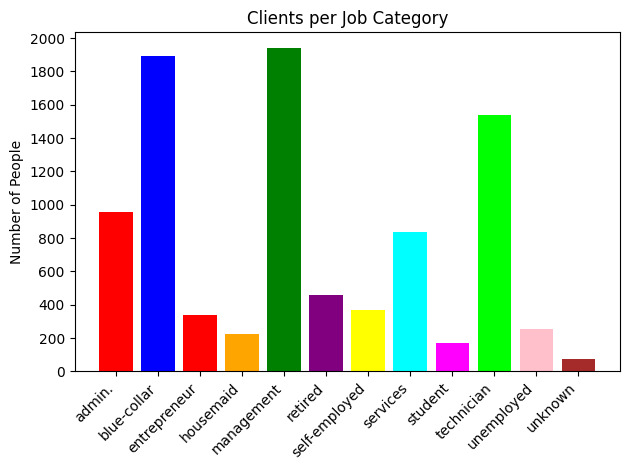

In [69]:
# Count how many people belong to each job category
cursor.execute("SELECT job, COUNT(job) as number_of_people FROM bank GROUP BY job")

rows = cursor.fetchall()
for row in rows:
    print(row)

# Make a bar chart visualization
fig, ax = plt.subplots()

jobs = [job for job, _ in rows]
counts = [count for _, count in rows]
bar_labels = ['red', 'blue', '_red', 'orange', 'green', 'purple', 'yellow', 'cyan',
              'magenta', 'lime', 'pink', 'brown']

bar_colors = ['red', 'blue', 'red', 'orange', 'green', 'purple',
              'yellow', 'cyan', 'magenta', 'lime', 'pink', 'brown']

ax.bar(jobs, counts, color=bar_colors)

ax.set_ylabel('Number of People')
ax.set_title('Clients per Job Category')

# Rotate the x-axis labels
plt.xticks(rotation=45, ha='right')
plt.yticks(ticks=list(range(0, 2001, 200)))

plt.tight_layout()  # Adjust the layout to ensure labels don't get cut off
plt.show()

In [70]:
# Find average yearly balances for each job category whose balance is greater than 0
cursor.execute("""SELECT job, AVG(balance) as average_balance FROM
               bank WHERE balance > 0 GROUP BY job;""")
rows = cursor.fetchall()
for row in rows:
    print(row)

# Find the largest average balance group
avg_balance = [balance for _, balance in rows]
idx = avg_balance.index(max(avg_balance))
idx
print("\nLargest balance category is :", rows[idx][0], "with avg. balance of", rows[idx][1])


('admin.', 1503.0680100755667)
('blue-collar', 1347.8520408163265)
('entrepreneur', 1881.986577181208)
('housemaid', 2548.141304347826)
('management', 2114.7880633373934)
('retired', 2685.85)
('self-employed', 1543.9583333333333)
('services', 1428.7981927710844)
('student', 1808.513888888889)
('technician', 1618.232198142415)
('unemployed', 1415.1666666666667)
('unknown', 1630.4285714285713)

Largest balance category is : retired with avg. balance of 2685.85


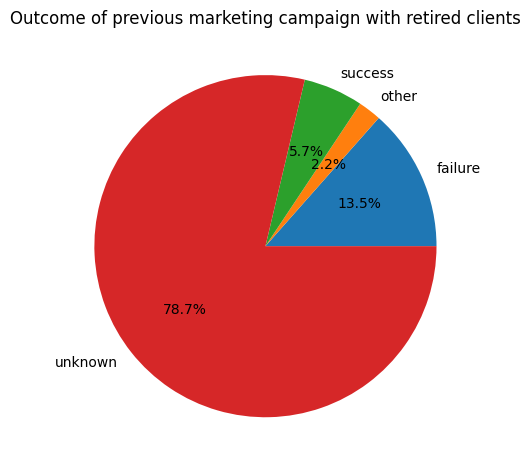

In [71]:
# What was the result of previous marketing campaign with the retired class people?
cursor.execute("""SELECT poutcome, COUNT(poutcome) as count
                FROM bank WHERE job="retired" GROUP BY poutcome;""")
rows = cursor.fetchall()

# Make a pie chart
labels = [label for label, _ in rows]
counts = [count for _, count in rows]
fig, ax = plt.subplots()
ax.pie(counts, labels=labels, autopct='%1.1f%%')
ax.set_title("Outcome of previous marketing campaign with retired clients")
plt.tight_layout()
plt.show()


# Small machine learning experiment

#### Let's use the data to see if we can predict success of the campaign. This is stored in y variable (has the client subscribed a term deposit? (binary: "yes","no")).

In [72]:
# Process the data before ML experiments

# Get datafram
df = pd.read_sql("SELECT * FROM bank;", conn)

# Check the number of missing values per column
missing_values = df.isna().sum()
print("Missing values")
print(missing_values) # No missing values

# Handle categorical variables
encoder = LabelEncoder()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns

# Initialize LabelEncoder
encoder = LabelEncoder()

# Transform categorical columns
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

# Split to independent and dependent variable
X = df.drop(columns=['y'])
y = df['y']

# Normalize data
scaler = StandardScaler()
X = scaler.fit_transform(X)



Missing values
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


In [73]:
# Split data to training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train random forest model
model = RandomForestClassifier()
model.fit(X_train, y_train)



RandomForestClassifier()

              precision    recall  f1-score   support

         Yes       0.99      0.98      0.99      1608
          No       0.86      0.96      0.91       201

    accuracy                           0.98      1809
   macro avg       0.93      0.97      0.95      1809
weighted avg       0.98      0.98      0.98      1809



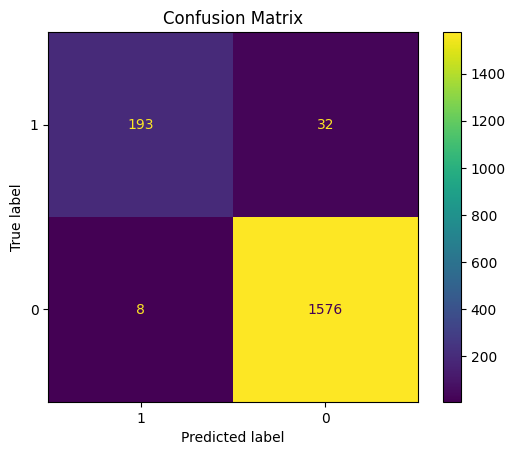

In [75]:
# Predict with test data
y_pred = model.predict(X_test)
target_names = ["Yes", "No"]

# Create classification report
print(classification_report(y_pred, y_test, target_names=target_names))

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred, labels =[1, 0])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1,0])
disp.plot()
plt.title("Confusion Matrix")

plt.show()
